# Feature Engineering

I'm going to outline a strategy similar to the fast.ai machine learning course. The general plan is to 
1. Build a simple, decent random forset model
2. Use this to understand which features are most imporatnt, focus on improving and expanding upon these features
3. Step back with improved features and try a set of models to find the best for this application
4. Tune hyperparamaters

First, though, I need a validation dataset. Since the goal is to predict into the future, I'll use the chronological end of my dataset for validation. If we take everything starting in 2017 and after, that will be ~15% of the total data

## Basic Model

First, I'll make a basic RF model, then use this to test the effect of adding some additional datasets on top of our data.

In [98]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

sns.set()
%matplotlib inline

In [99]:
data = pd.read_csv('sar_weather_df.csv')

validate = data[data.Year > 2016]
train = data[data.Year <= 2016]

print(train.shape, validate.shape)

(5461, 35) (820, 35)


In [100]:
print(train.columns)

# remove the date for RF training
train.drop('DATE', axis=1, inplace=True)
validate.drop('DATE', axis=1, inplace=True)

Index(['mission', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'DATE', 'AWND_x', 'PRCP_x',
       'TAVG_x', 'TMAX_x', 'TMIN_x', 'TSUN', 'WT01', 'WT02', 'WT03', 'WT05',
       'WT08', 'WT10', 'AWND_y', 'PRCP_y', 'SNWD', 'TAVG_y', 'TMAX_y',
       'TMIN_y', 'TOBS', 'WESD'],
      dtype='object')


/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [101]:
y_train = train['mission']
X_train = train.drop('mission', axis=1)

y_validate = validate['mission']
X_validate = validate.drop('mission', axis=1)

In [102]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train))
print(m.score(X_validate, y_validate))
print(m.oob_score_)

0.8655923823475554
0.6743902439024391
0.7220289324299579


The build in scoring functions probably aren't ideal, since there's only a mission 29% of the time. First, I'll calculate precision and recall and compare to a naive model that always predicts the major class (0).

In [103]:
y_score = [x[1] for x in m.predict_proba(X_validate)]

In [104]:
print(roc_auc_score(y_validate,y_score)) # my model
print(roc_auc_score(y_validate, 0.29*np.ones(len(y_validate)))) # naive model


0.621110400682012
0.5


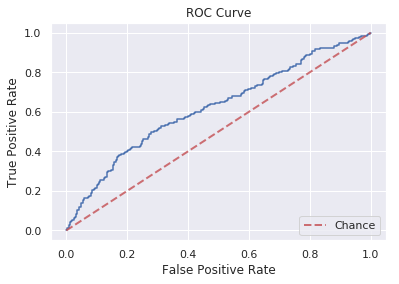

In [105]:
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [106]:
## Automate the splitting, training and validation

def split_train_val(data):
    validate = data[data.Year > 2016]
    train = data[data.Year <= 2016]

    train.drop('DATE', axis=1, inplace=True)
    validate.drop('DATE', axis=1, inplace=True)
    
    y_train = train['mission']
    X_train = train.drop('mission', axis=1)

    y_validate = validate['mission']
    X_validate = validate.drop('mission', axis=1)
    
    return X_train, y_train, X_validate, y_validate


def build_RF(X_train, y_train):
    m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('Training Score: ', m.score(X_train, y_train))
    print('OOB Score: ', m.oob_score_)
    return m
    
def test_RF(m, X_validate, y_validate):
    print('Validate Score: ',m.score(X_validate, y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate)]
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return True

                0           1
count  820.000000  820.000000
mean     0.655014    0.344986
std      0.105940    0.105940
min      0.294361    0.102827
25%      0.580784    0.274755
50%      0.664219    0.335781
75%      0.725245    0.419216
max      0.897173    0.705639


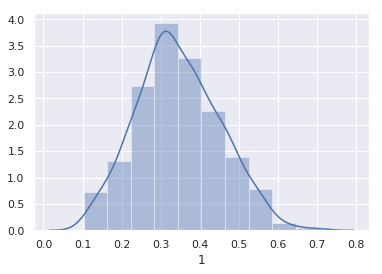

In [107]:
predictions = pd.DataFrame(m.predict_proba(X_validate))
sns.distplot(predictions[1], bins=10) #plot the prediction liklihood of a mission
print(predictions.describe())

Interesting. It's never more than 73% sure that a mission will happen. The negative predictive power is a bit better, getting as low as 12% liklihood. 

How can we improve our predictions? Add more features? Holidays? Google Data?

## Adding additional features

Let's consider twp ypes of data that are avaliable to add.
- Holiday data
- Google Trends

### Holiday Data

Let's start with the US federal holidays and add them to the dataset as a bool. We also expect that the days surrounding a holiday may see an increase or decrease in missions as well. 

We'll use a list of holidays from pandas

In [108]:
import pandas.tseries.holiday as hol

us_cal = hol.USFederalHolidayCalendar()
dr = pd.date_range(start='2002-01-01', end='2019-05-01')
us_holidays = us_cal.holidays(start=dr.min(), end=dr.max())

In [109]:
# Add column holiday bool to data

data['holiday'] = 0
data['DATE'] =  pd.to_datetime(data['DATE'], infer_datetime_format=True,
                              format='datetime64[ns]')
data['holiday'] = data.DATE.isin(us_holidays)

# Insert the number of days before and after closest holiday

holiday = data.holiday
since = []
d = 0
for i in range(len(holiday)):
    d += 1
    if holiday[i]:
        d = 0   # if it's a holiday, reset
    since.append(d)
#data['holiday_days_since'] = since

before = []
d = 0
for i in range(len(holiday)):
    d += 1
    if holiday[len(holiday) - (i+1)]:
        d = 0   # if it's a holiday, reset
    before.append(d)
#data['holiday_days_before'] = before

data['holiday_closest'] = np.minimum(since, before)

/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Score:  0.8615638161508881
OOB Score:  0.7201977659769273
Validate Score:  0.6780487804878049
ROC AUC:  0.6331788150042625


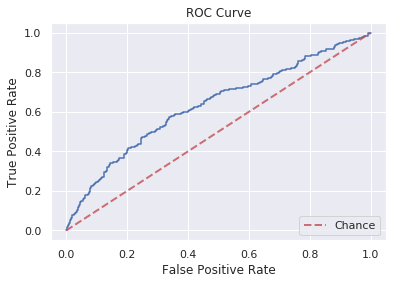

True

In [110]:
# Test it's effect on the model

X_train, y_train, X_validate, y_validate = split_train_val(data)
m = build_RF(X_train, y_train)
test_RF(m, X_validate, y_validate)

By testing out different combinations of these, it looks like the 'closest holiday' column without the 'before' and 'since' give the strongest improvement. It's a pretty minimal improvement, though.

### Google Trends Data

Positives - a cool feature of google trends are ...

This was a little bit annoying to get. Google scales the frequency of data output based on how much data you look at. So for example, if I download the entire dataset

In [112]:
trends = pd.read_csv('raw_data/googletrends_hiking.csv', header=None, names=['date_t', 'trend'])

trends['date_t'] =  pd.to_datetime(trends['date_t'], infer_datetime_format=True,
                              format='datetime64[ns]')

data = pd.merge(data, trends, how='outer', left_on='DATE', right_on='date_t')

/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


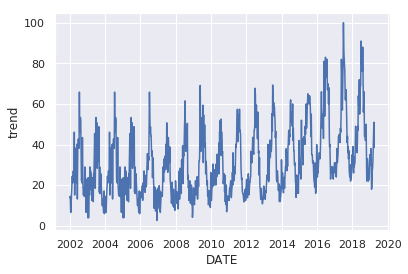

In [118]:
sns.lineplot(data.DATE, data.trend.interpolate())

In [120]:
data['trend'] = data.trend.interpolate(limit_direction='both')

In [121]:
data.drop('date_t', axis=1, inplace=True)

/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Score:  0.8846365134590735
OOB Score:  0.7196484160410181
Validate Score:  0.6743902439024391
ROC AUC:  0.6338714833759591


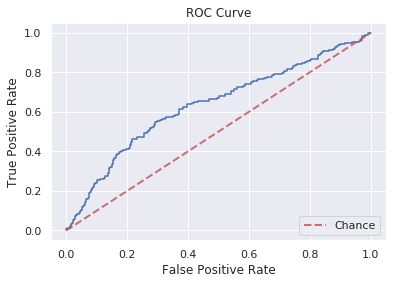

True

In [122]:
X_train, y_train, X_validate, y_validate = split_train_val(data)
m = build_RF(X_train, y_train)
test_RF(m, X_validate, y_validate)

In [123]:
data.shape

(6289, 38)

## Feature Importance

In [124]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, X_train); fi

,cols,imp
4,Dayofweek,0.081352
35,trend,0.078909
12,Elapsed,0.072479
13,AWND_x,0.059555
29,TMAX_y,0.059235
5,Dayofyear,0.059067
3,Day,0.056998
16,TMAX_x,0.055668
34,holiday_closest,0.053207
17,TMIN_x,0.051670


In [132]:
column_names = ['Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start','holiday']
data[column_names] = data[column_names].astype(bool)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6289 entries, 0 to 6288
Data columns (total 38 columns):
mission             6281 non-null float64
Year                6281 non-null float64
Month               6281 non-null float64
Week                6281 non-null float64
Day                 6281 non-null float64
Dayofweek           6281 non-null float64
Dayofyear           6281 non-null float64
Is_month_end        6289 non-null bool
Is_month_start      6289 non-null bool
Is_quarter_end      6289 non-null bool
Is_quarter_start    6289 non-null bool
Is_year_end         6289 non-null bool
Is_year_start       6289 non-null bool
Elapsed             6281 non-null float64
DATE                6281 non-null datetime64[ns]
AWND_x              6281 non-null float64
PRCP_x              6281 non-null float64
TAVG_x              6281 non-null float64
TMAX_x              6281 non-null float64
TMIN_x              6281 non-null float64
TSUN                6281 non-null float64
WT01                62

In [133]:
# Save the data table for now.
data.to_csv('sar_weather_df_postengineering.csv', index=False)